In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
!pip install torchvision

In [3]:
transform = transforms.Compose([
    transforms.Resize((96, 96))
    transforms.ToTensor()
])

train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 2640397119/2640397119 [02:32<00:00, 17357462.42it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [4]:
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [5]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.Tanh(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()
        )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x, freeze_layer=False):
        encoded = self.encoder(x)

        if freeze_layer:
            for param in self.encoder.parameters():
                param.requires_grad = False

        decoded = self.decoder(encoded)
        classification = self.classifier(encoded.view(encoded.size(0), -1))
        return decoded, classification

In [6]:
def train_autoencoder_layer(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for data in dataloader:
            inputs, _ = data
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
        print(f'Layer-wise Pretraining Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

In [7]:
def train_with_validation(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs, classifications = model(inputs)
            autoencoder_loss = criterion[0](outputs, inputs)
            classification_loss = criterion[1](classifications, labels)
            loss = autoencoder_loss + classification_loss
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            for data in valid_loader:
                inputs, labels = data
                outputs, classifications = model(inputs)
                autoencoder_loss = criterion[0](outputs, inputs)
                classification_loss = criterion[1](classifications, labels)
                valid_loss += autoencoder_loss.item() + classification_loss.item()

            valid_loss /= len(valid_loader)
            print(f'Training Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {valid_loss}')

In [8]:
def evaluate(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs, classifications = model(inputs)
            _, predictions = torch.max(classifications, 1)
            all_labels.extend(labels.numpy())
            all_predictions.extend(predictions.numpy())
    return all_labels, all_predictions

autoencoder = ConvAutoencoder()
criterion_autoencoder = nn.MSELoss()
criterion_classifier = nn.CrossEntropyLoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

for i in range(3):
    train_autoencoder_layer(autoencoder, train_loader, criterion_autoencoder, optimizer, num_epochs=1)

criterion = [criterion_autoencoder, criterion_classifier]
train_with_validation(autoencoder, train_loader, valid_loader, criterion, optimizer, num_epochs=3)

labels, predictions = evaluate(autoencoder, test_loader)

conf_matrix = confusion_matrix(labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 3, 96, 96])) that is different to the input size (torch.Size([64, 3, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 96, 96])) that is different to the input size (torch.Size([8, 3, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Layer-wise Pretraining Epoch 1/1, Loss: 0.06422877311706543
Layer-wise Pretraining Epoch 1/1, Loss: 0.06493458151817322
Layer-wise Pretraining Epoch 1/1, Loss: 0.03720789775252342


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([40, 3, 96, 96])) that is different to the input size (torch.Size([40, 3, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training Epoch 1/3, Loss: 1.5692585706710815, Validation Loss: 1.890211436431855
Training Epoch 2/3, Loss: 1.6068967580795288, Validation Loss: 1.7196124976035208
Training Epoch 3/3, Loss: 1.5166575908660889, Validation Loss: 1.6996996679808944
Confusion Matrix:
[[458  46  11   3   5  51  19  32  92  83]
 [ 58 112   1   2 144  92 135 240   3  13]
 [ 15  12  85   1   1  11  58  30  12 575]
 [  2  16   1  16 143 113 199 294   3  13]
 [  7  23   0   2 358  59 137 209   1   4]
 [  4  11   1   3 175 146 183 266   3   8]
 [  1  20   1   1 117  59 401 175   0  25]
 [  2   9   0   4 182  60 163 376   1   3]
 [140  27   1   0   4  46  26  23 330 203]
 [ 29  14   5   3   4  23  75  31  46 570]]


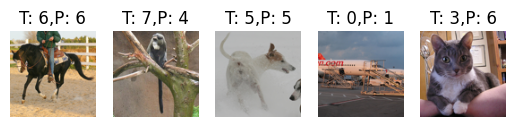

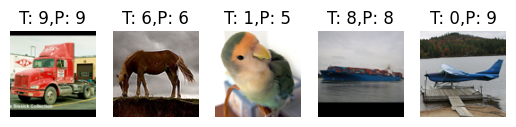

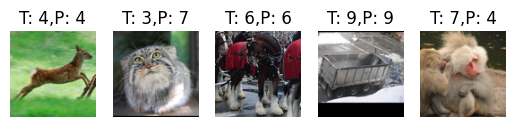

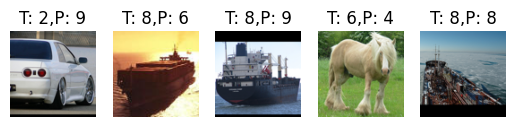

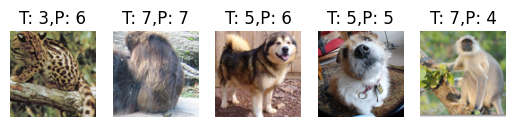

In [9]:
def visualize_classified_images(model, dataloader, num_images=10):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            outputs, classifications = model(inputs)
            _, predicted = torch.max(classifications, 1)

            for j in range(num_images):
                plt.subplot(1, num_images, j + 1)
                plt.imshow(np.transpose(inputs[j].numpy(), (1, 2, 0)))
                plt.title(f'T: {labels[j]},P: {predicted[j]}')
                plt.axis('off')

            plt.show()

            if i + 1 >= num_images:
                break

visualize_classified_images(autoencoder, test_loader, num_images=5)

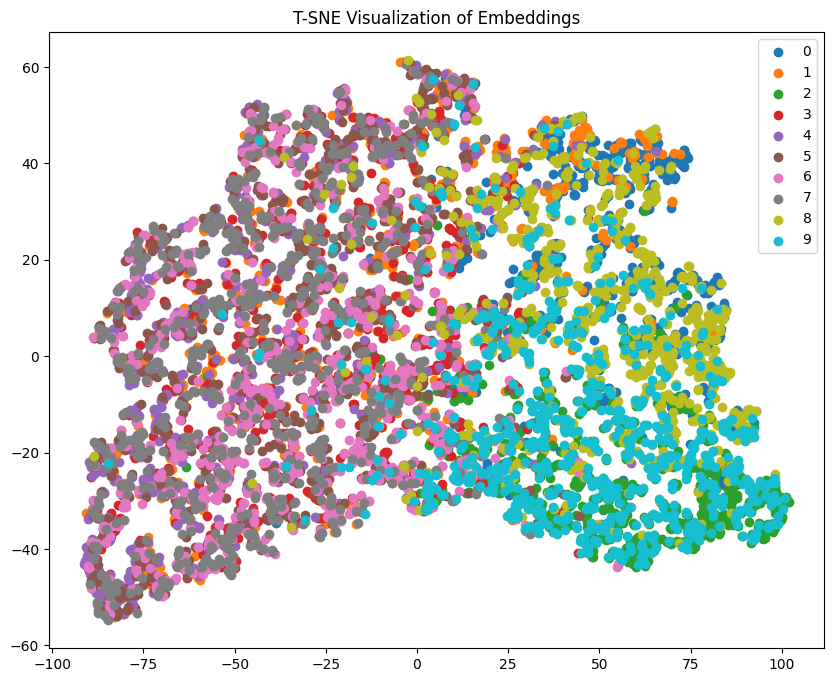

In [10]:
def visualize_tsne(model, dataloader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in dataloader:
            inputs, lbls = data
            _, encoded = model(inputs)
            embeddings.append(encoded.numpy())
            labels.append(lbls.numpy())
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)

    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    for i in range(10): 
        indices = labels == i
        plt.scatter(embeddings_tsne[indices, 0], embeddings_tsne[indices, 1], label=str(i))
    plt.legend()
    plt.title("T-SNE Visualization of Embeddings")
    plt.show()

visualize_tsne(autoencoder, test_loader)
